# Generative Adversarial Network for ECG synthesis
This notebook is an addition to this [notebook](https://www.kaggle.com/polomarco/ecg-classification-cnn-lstm-attention-mechanism).

C:\Users\jespe\AppData\Local\Temp\ipykernel_20432\574050403.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(io.imread("https://i.pinimg.com/originals/97/c8/0e/97c80e536a8b8712a8299dddb9f14e07.jpg"))


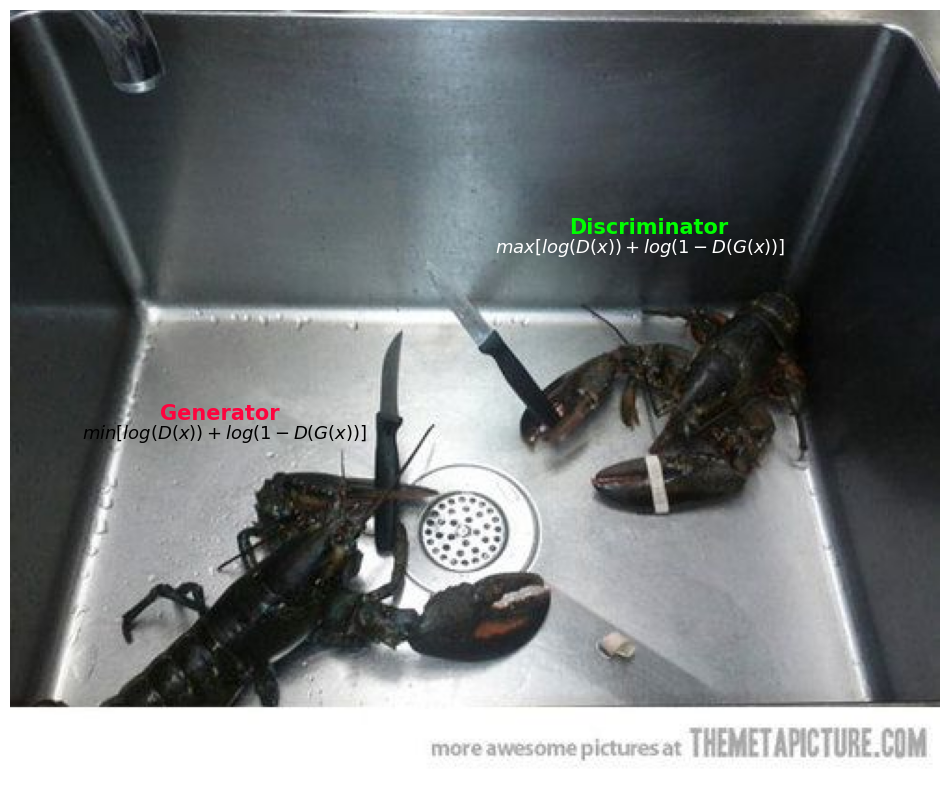

In [9]:
import matplotlib.pyplot as plt
import cv2
import imageio as io

lat_D = 'max[log(D(x))+log(1-D(G(x))]'
lat_G = 'min[log(D(x))+log(1-D(G(x))]'

plt.figure(figsize=(12, 10))
plt.imshow(io.imread("https://i.pinimg.com/originals/97/c8/0e/97c80e536a8b8712a8299dddb9f14e07.jpg"))
plt.axis('off');

plt.text(80, 220, "Generator", 
         fontdict={
             "fontsize":15,
             "color":"#FF033E",
             "weight": "bold"
             }
         );
plt.text(38, 230, r"$%s$" % lat_G, 
         fontdict={
             "fontsize":13,
             "color":"black",
             "weight": "bold"
             }
         );
                                                                                               
plt.text(300, 120, r"Discriminator", 
         fontdict={
             "fontsize":15,
             "color":"lime",
             "weight": "bold"
             }
         );
         
plt.text(260, 130, r"$%s$" % lat_D,
         fontdict=
         {"fontsize":13,
          "color":"white",
          "weight": "bold"
          }
         );

![](https://64.media.tumblr.com/66dc00e688f72af4d7b5d768005359c4/094fefb7e60b17ee-9c/s500x750/3060385c5fdcb38f3a716d8a309a40e69e598a5f.png)

In [11]:
import os
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, Adam


In [13]:
# Def to combine all CSV files in a directory into a single DataFrame
def combine_csv_files_to_df(dir_path):
    # Get all CSV files in the directory
    csv_files = [file for file in os.listdir(dir_path) if file.endswith('.csv')]

    df_list = [pd.read_csv(os.path.join(dir_path, file), header=None) for file in csv_files]
    combined_data = pd.concat(df_list, ignore_index=True,)

    # Display the combined DataFrame
    return(combined_data)


In [14]:
class Config:
    csv_path = ''
    seed = 2021
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
config = Config()
seed_everything(config.seed)

In [15]:
# df_ptbdb = pd.read_csv('/kaggle/input/heartbeat/ptbdb_abnormal.csv')
df_mitbih = combine_csv_files_to_df('./Dataset_mitbih/Training/')
df_mitbih.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
df_mitbih_train = combine_csv_files_to_df('./Dataset_mitbih/Training/')
df_mitbih_test = combine_csv_files_to_df('./Dataset_mitbih/Testing/')
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'class'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)
print(df_mitbih.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 189 entries, 0 to label
dtypes: float64(188), object(1)
memory usage: 158.7+ MB
None


In [17]:
df_mitbih.to_csv('data.csv', index=False)
config.csv_path = 'data.csv'

# Basic EDA

In [18]:
df_mitbih['label'].value_counts()

Normal                               90589
Fusion of paced and normal            8039
Premature ventricular contraction     7236
Artial Premature                      2779
Fusion of ventricular and normal       803
Name: label, dtype: int64

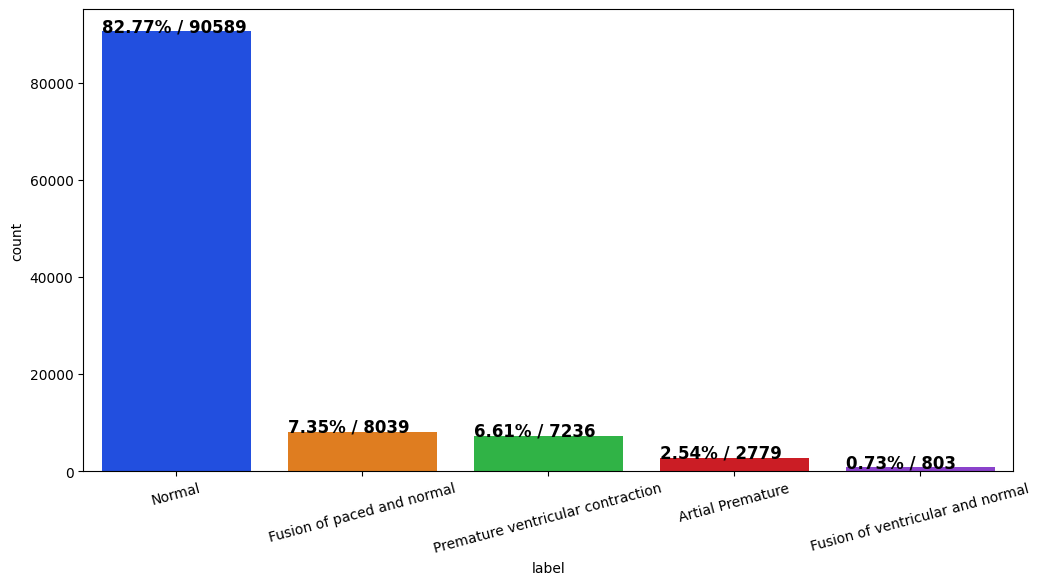

In [19]:
percentages = [count / df_mitbih.shape[0] * 100 for count in df_mitbih['label'].value_counts()]

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(
    x=df_mitbih['label'],
    ax=ax,
    palette="bright",
    order=df_mitbih['label'].value_counts().index
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15);

for percentage, count, p in zip(
    percentages,
    df_mitbih['label'].value_counts(sort=True).values,
    ax.patches):
    
    percentage = f'{np.round(percentage, 2)}%'
    x = p.get_x() + p.get_width() / 2 - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(str(percentage)+" / "+str(count), (x, y), fontsize=12, fontweight='bold')
    
plt.savefig('data_dist.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('data_dist.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

# Dataset

In [20]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-2].tolist()

    def __getitem__(self, idx):
        signal = self.df.loc[idx, self.data_columns].astype('float32')
        signal = torch.FloatTensor([signal.values])                 
        target = torch.LongTensor(np.array(self.df.loc[idx, 'class']))
        return signal, target

    def __len__(self):
        return len(self.df)

def get_dataloader(label_name, batch_size):
    df = pd.read_csv(config.csv_path)
    df = df.loc[df['label'] == label_name]
    df.reset_index(drop=True, inplace=True)
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0)
    return dataloader
    
    
dataloader = get_dataloader(label_name='Artial Premature', batch_size=96)

print(len(dataloader))
x,y = next(iter(dataloader))
x.shape, y.shape

29


C:\Users\jespe\AppData\Local\Temp\ipykernel_20432\3944258185.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  signal = torch.FloatTensor([signal.values])


(torch.Size([96, 1, 187]), torch.Size([96]))

# Models

In [21]:
import torch.nn as nn
import torch.nn.functional as F


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 187)
        self.rnn_layer = nn.LSTM(
                input_size=187,
                hidden_size=128,
                num_layers=1,
                bidirectional=True,
                batch_first=True,
            )
    def forward(self, x):
        x,_ = self.rnn_layer(x)
        x = x.view(-1,256)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        x = self.fc3(x)
        return x.unsqueeze(1)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.rnn_layer = nn.LSTM(
                input_size=187,
                hidden_size=256,
                num_layers=1,
                bidirectional=True,
                batch_first=True,
            )
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 256) 
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x,_ = self.rnn_layer(x)
        x = x.view(-1, 512)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        x = torch.sigmoid(self.fc3(x))
        return x

# Training stage

In [22]:
class Trainer:
    def __init__(
        self,
        generator,
        discriminator,
        batch_size,
        num_epochs,
        label
    ):
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        self.netG = generator.to(self.device)
        self.netD = discriminator.to(self.device)
        
        self.optimizerD = Adam(self.netD.parameters(), lr=0.0002)
        self.optimizerG = Adam(self.netG.parameters(), lr=0.0002)
        self.criterion = nn.BCELoss()
        
        self.batch_size = batch_size
        self.signal_dim = [self.batch_size, 1, 187]
        self.num_epochs = num_epochs
        self.dataloader = get_dataloader(
            label_name=label, batch_size=self.batch_size
        )
        self.fixed_noise = torch.randn(self.batch_size, 1, 187,
                                       device=self.device)
        self.g_errors = []
        self.d_errors = []
        
    def _one_epoch(self):
        real_label = 1
        fake_label = 0
        
        for i, data in enumerate(self.dataloader, 0):
            ##### Update Discriminator: maximize log(D(x)) + log(1 - D(G(z))) #####
            ## train with real data
            self.netD.zero_grad()
            real_data = data[0].to(self.device)
            # dim for noise
            batch_size = real_data.size(0)
            self.signal_dim[0] = batch_size
            
            label = torch.full((batch_size,), real_label,
                           dtype=real_data.dtype, device=self.device)
            
            output = self.netD(real_data)
            output = output.view(-1)
       
            errD_real = self.criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()
            
            ## train with fake data
            noise = torch.randn(self.signal_dim, device=self.device)
            fake = self.netG(noise)
            label.fill_(fake_label)
            
            output = self.netD(fake.detach())
            output = output.view(-1)
            
            errD_fake = self.criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake 
            self.optimizerD.step()
            
            ##### Update Generator: maximaze log(D(G(z)))  
            self.netG.zero_grad()
            label.fill_(real_label) 
            output = self.netD(fake)
            output = output.view(-1)
            
            errG = self.criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            self.optimizerG.step()
            
        return errD.item(), errG.item()
        
    def run(self):
        for epoch in range(self.num_epochs):
            errD_, errG_ = self._one_epoch()
            self.d_errors.append(errD_)
            self.g_errors.append(errG_)
            if epoch % 300 == 0:
                print(f"Epoch: {epoch} | Loss_D: {errD_} | Loss_G: {errG_} | Time: {time.strftime('%H:%M:%S')}")
   
                fake = self.netG(self.fixed_noise)
                plt.plot(fake.detach().cpu().squeeze(1).numpy()[:].transpose())
                plt.show()
            
        torch.save(self.netG.state_dict(), f"generator.pth")
        torch.save(self.netG.state_dict(), f"discriminator.pth")

In [23]:
g = Generator()
d = Discriminator()

Epoch: 0 | Loss_D: 1.351273775100708 | Loss_G: 0.7130661606788635 | Time: 10:36:38


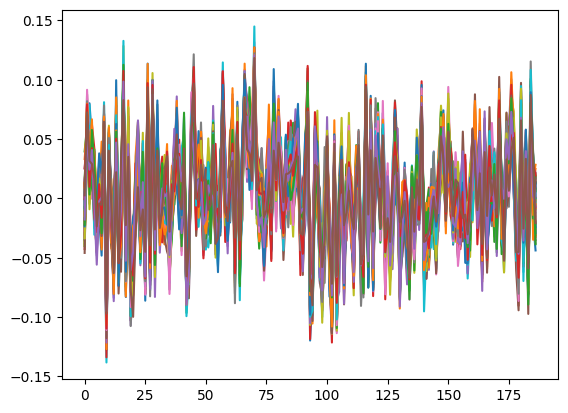

Epoch: 300 | Loss_D: 0.4547562599182129 | Loss_G: 3.6439268589019775 | Time: 10:42:12


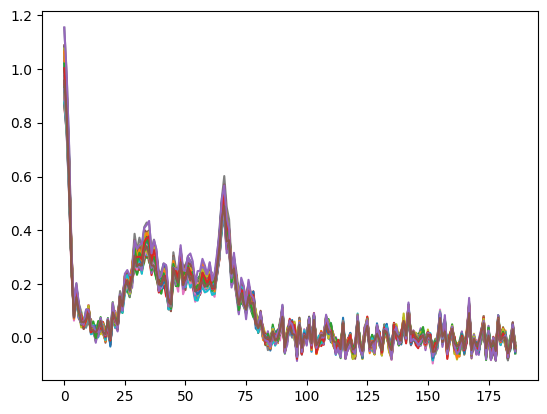

Epoch: 600 | Loss_D: 0.42273178696632385 | Loss_G: 2.826059579849243 | Time: 10:47:40


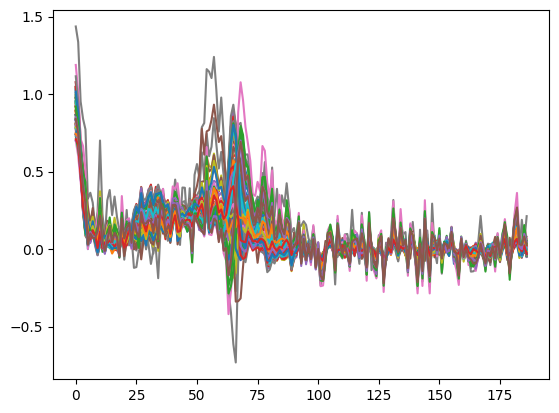

Epoch: 900 | Loss_D: 0.6400747299194336 | Loss_G: 2.3721184730529785 | Time: 10:53:14


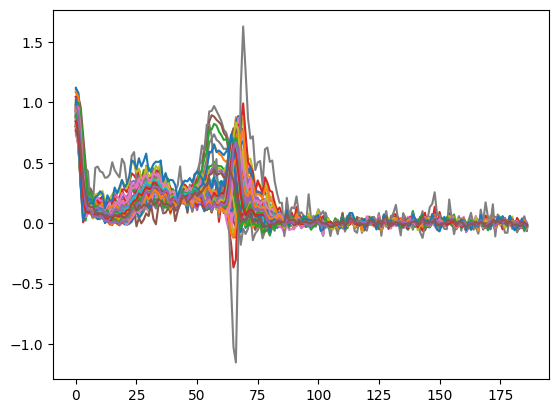

Epoch: 1200 | Loss_D: 0.4868130683898926 | Loss_G: 2.04253888130188 | Time: 10:58:42


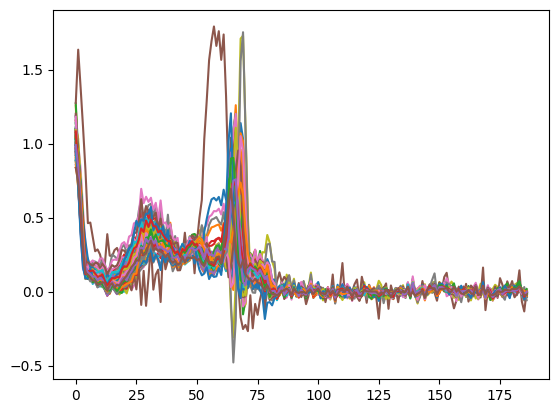

Epoch: 1500 | Loss_D: 0.8372600078582764 | Loss_G: 1.625250220298767 | Time: 11:04:09


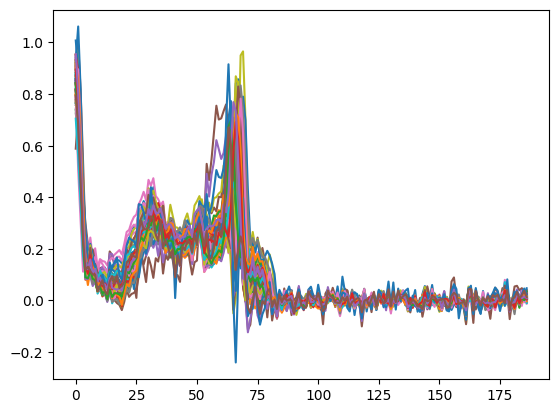

Epoch: 1800 | Loss_D: 1.0780466794967651 | Loss_G: 1.869691014289856 | Time: 11:09:32


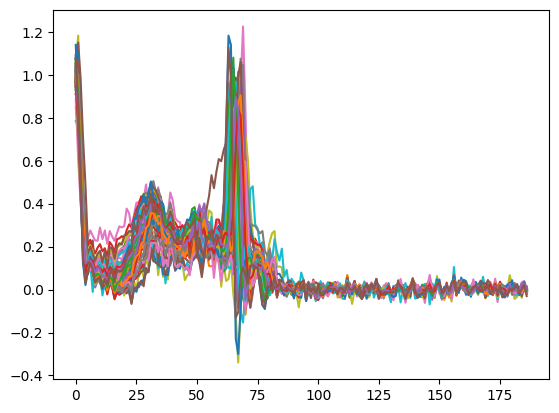

Epoch: 2100 | Loss_D: 1.185067892074585 | Loss_G: 1.3075568675994873 | Time: 11:15:12


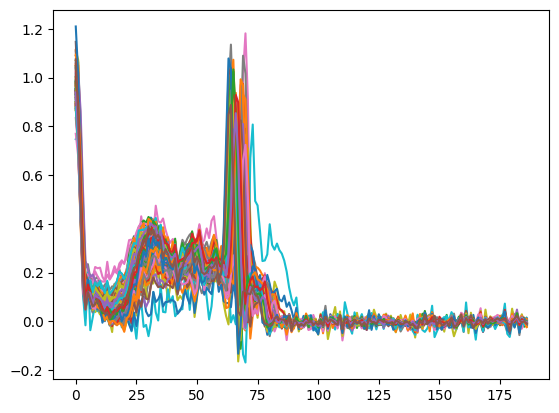

Epoch: 2400 | Loss_D: 1.089353084564209 | Loss_G: 2.675860643386841 | Time: 11:21:06


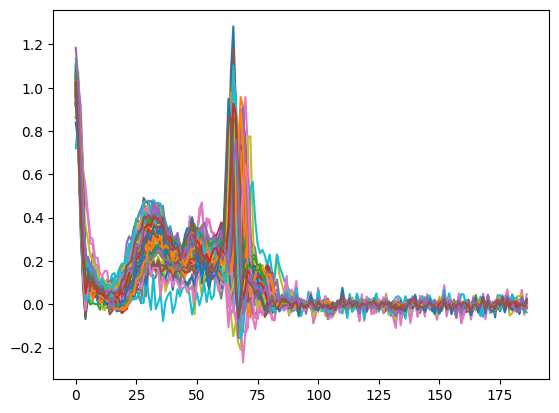

Epoch: 2700 | Loss_D: 1.2481001615524292 | Loss_G: 1.6603045463562012 | Time: 11:27:05


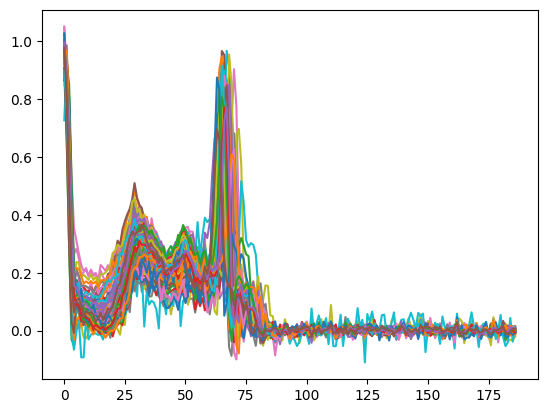

In [24]:
trainer = Trainer(
    generator=g,
    discriminator=d,
    batch_size=96,
    num_epochs=3000,
    label='Fusion of ventricular and normal'
)
trainer.run()

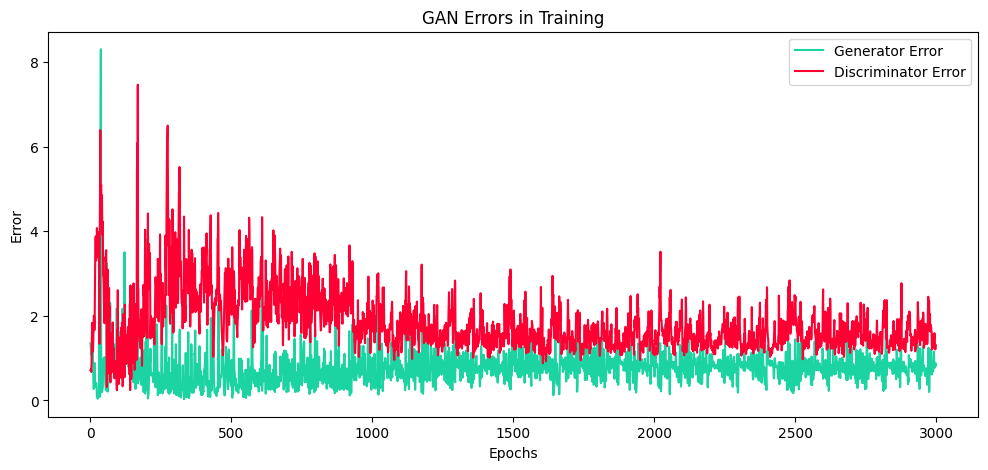

In [25]:
plt.figure(figsize=(12, 5))
plt.title("GAN Errors in Training")
plt.plot(trainer.d_errors, label='Generator Error', c='#1CD3A2')
plt.plot(trainer.g_errors, label='Discriminator Error', c='#FF0033')
plt.xlabel("Epochs")
plt.ylabel('Error')
_ = plt.legend()
plt.savefig('Gan_Losses.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('Gan_Losses.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

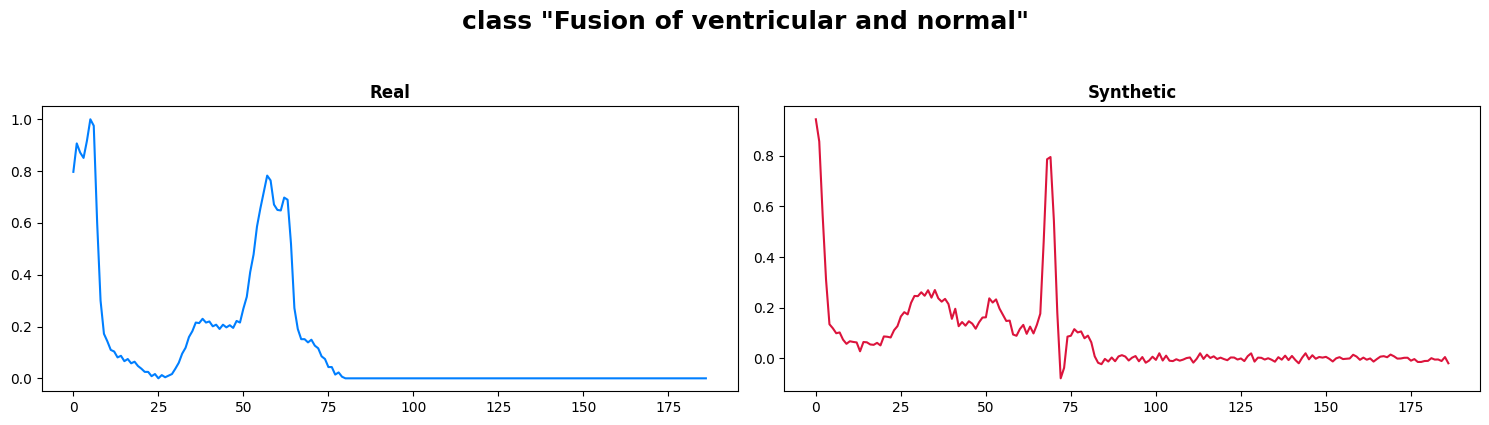

In [26]:
df = pd.read_csv(config.csv_path)
df = df.loc[df['label'] == 'Fusion of ventricular and normal']

# real signal
N = 1
real_samples =  df.sample(N).values[:, :-2].transpose()

#synthetic signal
fake = trainer.netG(trainer.fixed_noise)
index = np.random.choice(fake.shape[0], N, replace=False) 
synthetic_samples = fake.detach().cpu().squeeze(1).numpy()[index].transpose()

fig, axs = plt.subplots(1, 2, figsize=(15, 4))


axs[0].plot(real_samples, c='#007FFF')
axs[0].set_title("Real", fontsize= 12, weight="bold")


axs[1].plot(synthetic_samples, c="crimson")
axs[1].set_title("Synthetic", fontsize= 12, weight="bold")

plt.suptitle('class "Fusion of ventricular and normal"', fontsize=18, y=1.05, weight="bold")
plt.tight_layout()
plt.savefig('Fusion_of_ventricular_and_normal.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('Fusion_of_ventricular_and_normal.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

In [33]:
import pandas as pd
import numpy as np

# assume you have a trained generator function called "generate_sample"
# that takes a noise vector as input and returns a generated sample
# set the number of samples to generate
num_samples = 100

# set the dimensionality of the noise vector to match the generator input
noise_dim = 100

# create an empty list to hold the generated samples
samples = []

# convert the list of samples to a pandas DataFrame
df = pd.DataFrame()

# generate X samples using the generator
for i in range(num_samples):
    # generate random noise vector
    noise = np.random.normal(0, 1, noise_dim)
    # generate a sample using the generator
    fake = trainer.netG(trainer.fixed_noise)
    index = np.random.choice(fake.shape[0], N, replace=False) 
    synthetic_samples = fake.detach().cpu().squeeze(1).numpy()[index].transpose()
    # Reshape the sample to be 1D
    synthetic_samples = synthetic_samples.reshape(1, -1)

    # add synthetic sample to the df as a row
    df = df.append(pd.DataFrame(synthetic_samples))


# save the DataFrame to a CSV file
df.to_csv('generated_samples.csv', index=False)

C:\Users\jespe\AppData\Local\Temp\ipykernel_20432\1956306413.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(synthetic_samples))
C:\Users\jespe\AppData\Local\Temp\ipykernel_20432\1956306413.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(synthetic_samples))
C:\Users\jespe\AppData\Local\Temp\ipykernel_20432\1956306413.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(synthetic_samples))
C:\Users\jespe\AppData\Local\Temp\ipykernel_20432\1956306413.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(synthetic_sample

In [34]:
# load the DataFrame from the CSV file
df_generated = pd.read_csv('generated_samples.csv')
df_generated

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,1.083476,0.848208,0.520880,0.247265,0.072112,0.133443,0.127738,0.114514,0.086058,0.060776,...,-0.000147,-0.003944,0.002554,-0.005665,0.001799,-0.002463,-0.011625,0.009305,-0.004188,-0.010346
1,1.014003,0.871888,0.604432,0.323700,0.092453,0.123794,0.120008,0.094246,0.076480,0.062611,...,-0.003205,-0.009056,0.002235,0.001564,0.013921,0.005819,0.003618,0.003433,-0.004622,-0.006216
2,1.021125,0.774355,0.396998,0.123924,0.011553,0.086336,0.090934,0.065769,0.064716,0.049814,...,-0.001119,-0.004585,0.006799,0.002144,-0.008041,0.004193,-0.001035,-0.005441,-0.006256,0.001479
3,0.960464,0.884253,0.647042,0.344863,0.169395,0.120904,0.132687,0.078283,0.069918,0.086453,...,-0.001150,0.009212,0.010540,0.016325,0.000453,0.001988,0.003461,-0.006200,0.006756,-0.005168
4,0.757674,0.993747,0.888965,0.537462,0.330222,0.226859,0.142710,0.096610,0.109158,0.101752,...,0.005769,-0.014262,0.006505,0.017285,0.011068,0.013622,-0.018582,0.008079,0.037700,-0.003498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.009930,0.730301,0.340478,0.118715,0.021140,0.138925,0.132339,0.117877,0.116724,0.089722,...,-0.006993,-0.003467,0.013336,-0.003772,-0.002103,-0.005267,-0.014352,0.006142,-0.010702,-0.005785
96,1.066344,0.849308,0.547199,0.265376,0.088426,0.145603,0.129353,0.114743,0.087172,0.066267,...,-0.003887,-0.008196,-0.001440,-0.006980,0.003072,0.002720,-0.004448,0.009322,-0.000222,-0.004415
97,0.980256,0.862930,0.563022,0.270062,0.100604,0.103010,0.071155,0.052636,0.035642,0.031513,...,-0.004107,-0.008622,0.006565,0.002158,0.000809,0.004866,0.007852,0.004698,0.005180,-0.001472
98,1.084898,0.832551,0.510025,0.261716,0.074000,0.152582,0.150116,0.135249,0.106489,0.083427,...,-0.000567,-0.003870,-0.001530,-0.006736,0.009315,0.001888,-0.006784,0.006184,-0.005448,-0.004263


# Conclusion
Since this is a standard process for training a GAN model, we can observe that the Generator produces predominantly dominant signal types.
More specifically, we have a total of 803 signals of the '"Fusion of ventricular and normal"' class, most of which are very similar, and that's what GAN model learned to generate.